<h1>Environment</h1>

Verify that we have the correct version of astropy:

In [1]:
import astropy
print(astropy.__version__)

3.2.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u

<h1>Data input</h1>

Begin by importing the helper functions in the 'proto' package:

In [3]:
import fit_functions_specutils
from specutils import Spectrum1D, SpectralRegion

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be included in fit: simple 2-column ASCII file

In [4]:
datafile = "../../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../../data/n5548/n5548_lyalpha_sample.dat"

The read_file function reads the spectrum file and an optional regions file. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Regions is a list of SpectralRegion instances, one per region in the regions file.

Mask is a float numpy array with 1's for data points in regions and 0's for data points outside regions. The regions file was built originally to select continuum regions, that is, outside lines. We invert the mask so as to select data points corresponding to line regions. We won't be using it directly, but it is useful information to check against whatever the line finder algorithms detect. 

In [5]:
spectrum, regions, mask = fit_functions_specutils.read_file(datafile, regions=regionsfile)

line_mask = np.where(mask > 0., 0., 1.)

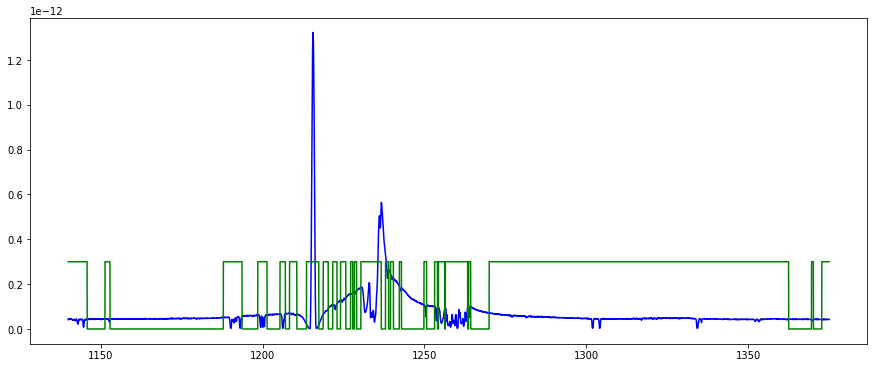

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, line_mask*3.E-13, 'g')

<h1>Line finding</h1>

Even though the spectrum carries an uncertainity attribute derived from the errors (defined in the input file), we find that the line finder performs better when supplied with a noise level computed from a featureless continuum region. The ope

In [8]:
from specutils.manipulation import noise_region_uncertainty

noise_region = SpectralRegion(1160*u.AA, 1185*u.AA)
spectrum = noise_region_uncertainty(spectrum, noise_region)

Now, find lines:

In [9]:
from specutils.fitting import find_lines_threshold

lines = find_lines_threshold(spectrum, noise_factor=30)

In [10]:
print(lines)

line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------
   1140.306  emission                 8
  1143.7593  emission                97
 1189.27303  emission              1270
 1192.53232  emission              1354
 1198.54649  emission              1509
 1199.71053  emission              1539
 1200.29255  emission              1554
 1205.25909  emission              1682
 1208.24678  emission              1759
 1215.61899  emission              1949
  1236.7268  emission              2493
 1263.65479  emission              3187
 1302.68872  emission              4193
 1327.17223  emission              4824
  1336.5233  emission              5065


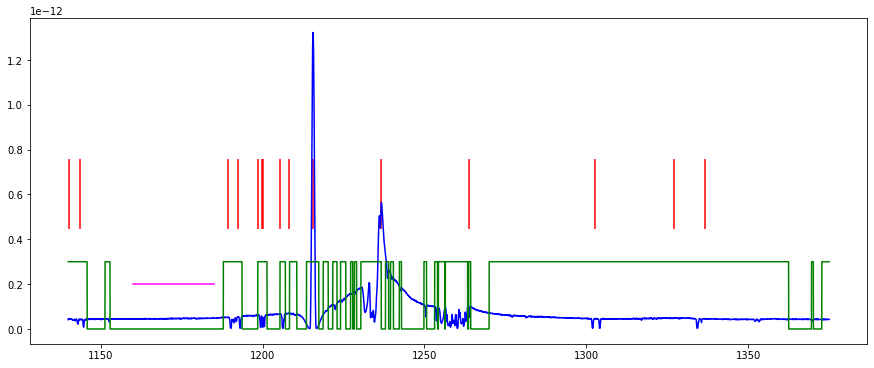

In [11]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, line_mask*3.E-13, 'g')

# noise region
plt.plot(np.array([noise_region.lower.value, noise_region.upper.value]), np.array([2.E-13,2.E-13]), 'magenta')

# found lines
marker_style = dict(marker='|', color='red', s=5000)
plt.scatter(lines['line_center'], (np.ones(len(lines['line_center']))*6.E-13), **marker_style)

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

The actual fitting then is a very simple operation. First, we instantiate a fitter engine:

In [12]:
# import astropy.modeling.fitting as fitting

In [13]:
# fitter = fitting.LevMarLSQFitter()

And the fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed. Let's do some timing as well:

In [14]:
# import time
# start_time = time.time()

# fit_result = fitter(compound_model, spectrum.spectral_axis.data, spectrum.flux.data, acc=1.E-30, maxiter=6000)

# end_time = time.time()

# print(end_time - start_time)

In [15]:
# print(fitter.fit_info['message'])

The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [16]:
# print(fit_result)

<h1>Plots</h1>

<h3>Input and output compound models</h3>

In [17]:
# plt.gcf().set_size_inches(15.,6.)
# plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
# fitted_spectrum = fit_result(spectrum.spectral_axis.data)
# plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'g')

<h3>Input compound model overploted on spectrum</h3>

In [18]:
# plt.gcf().set_size_inches(15.,6.)
# plt.ylim(0., 6.e-13)
# plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
# plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
# plt.plot(spectrum.spectral_axis.data, mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

In [19]:
# plt.gcf().set_size_inches(15.,6.)
# plt.ylim(0., 6.e-13)
# plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
# plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'r')
# plt.plot(spectrum.spectral_axis.data, mask*8.E-14, 'g')

<h3>Residuals</h3>

input spectrum - input model: plotted in yellow

input spectrum - fitted model: plotted in blue

In [20]:
# residuals = spectrum.flux.data - fitted_spectrum
# original_residuals = spectrum.flux.data - compound_model(spectrum.spectral_axis.data)

In [21]:
# plt.gcf().set_size_inches(15.,6.)
# plt.ylim(-2.e-13, 2.e-13)
# plt.plot([1100., 1400], [0., 0.], 'r')
# plt.plot(spectrum.spectral_axis.data, residuals, 'b')
# plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
# plt.plot(spectrum.spectral_axis.data, (mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

In [22]:
# plt.gcf().set_size_inches(15.,5.)
# plt.xlim(1185., 1270.)
# plt.ylim(-2.e-13, 0.7e-13)
# plt.plot([1185., 1270], [0., 0.], 'r')
# plt.plot(spectrum.spectral_axis.data, residuals, 'b')
# plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
# plt.plot(spectrum.spectral_axis.data, (mask-0.5)*5.E-14, 'g')